In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

In [2]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
            
    return pd.read_csv(Path("datasets/housing/housing.csv"))



In [3]:
housing = load_housing_data()

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
import matplotlib.pyplot as plt

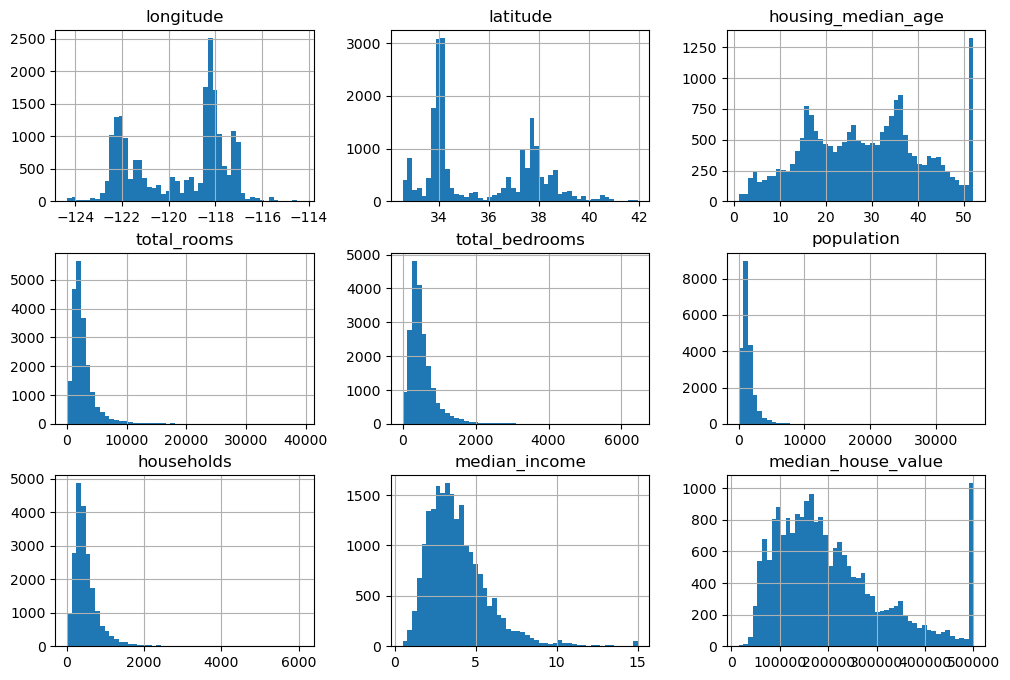

In [9]:
housing.hist(bins=50, figsize=(12,8))
plt.show()

In [10]:
import numpy as np

In [11]:
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)

In [13]:
len(train_set)

16512

In [14]:
len(test_set)

4128

In [15]:
np.random.seed(42)

In [16]:
from zlib import crc32

In [17]:
def is_id__in_test_set(inditifier, test_ratio):
    return crc32(np.int64(inditifier)) < test_ratio *2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id__in_test_set(id_,test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [18]:
housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [19]:
housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [20]:
from sklearn.model_selection import train_test_split 

In [21]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [22]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0.,1.5,3.0,4.5,6., np.inf], labels=[1,2,3,4,5])

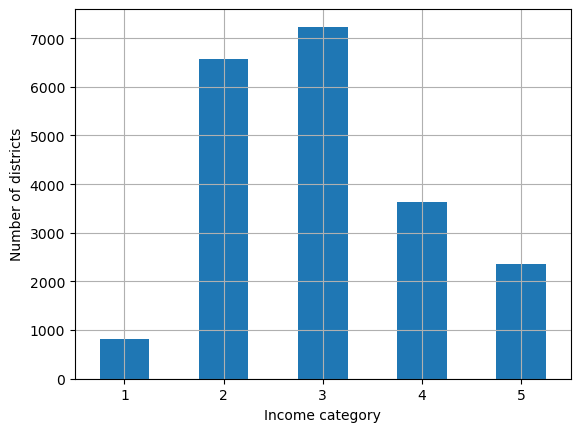

In [23]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

In [27]:
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])



In [28]:
strat_train_set, strat_test_set = strat_splits[0]

In [29]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [31]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [32]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [33]:
housing = strat_train_set.copy()

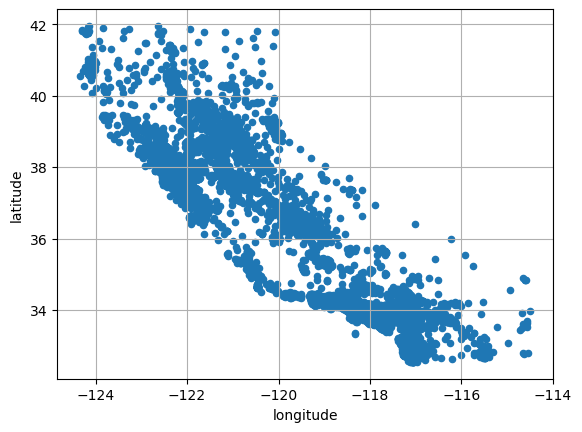

In [34]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid="True")
plt.show()

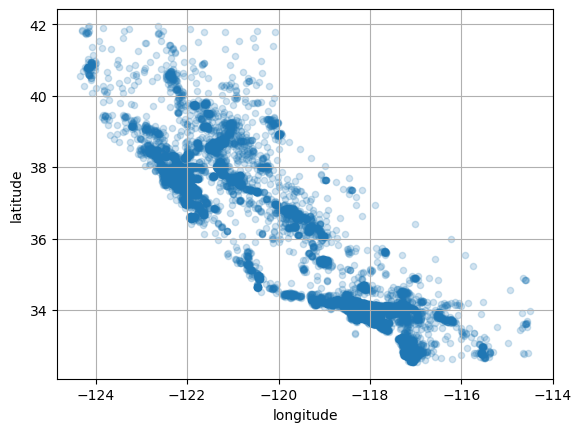

In [35]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid="True", alpha=0.2)
plt.show()

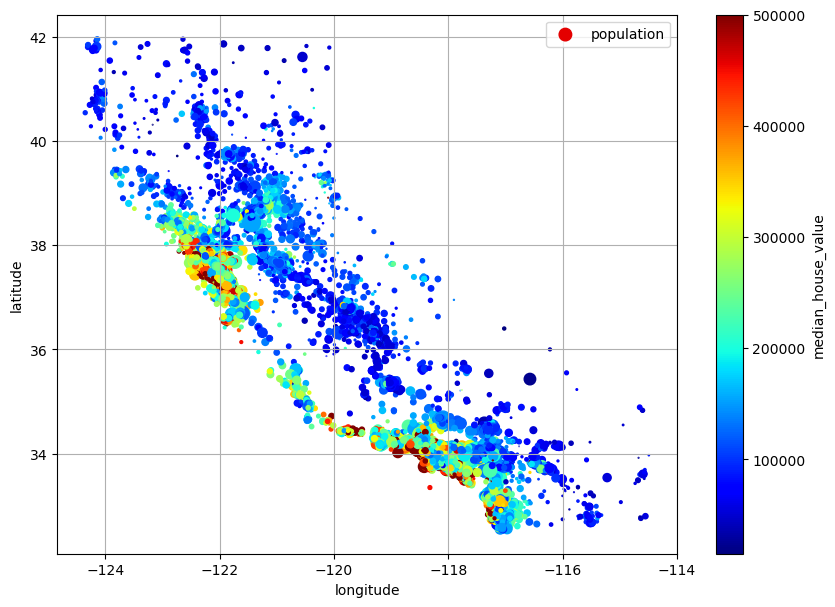

In [36]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"]/100, label="population", c="median_house_value", 
             cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10,7))
plt.show()


In [41]:
import sys
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

Saving figure california_housing_prices_plot


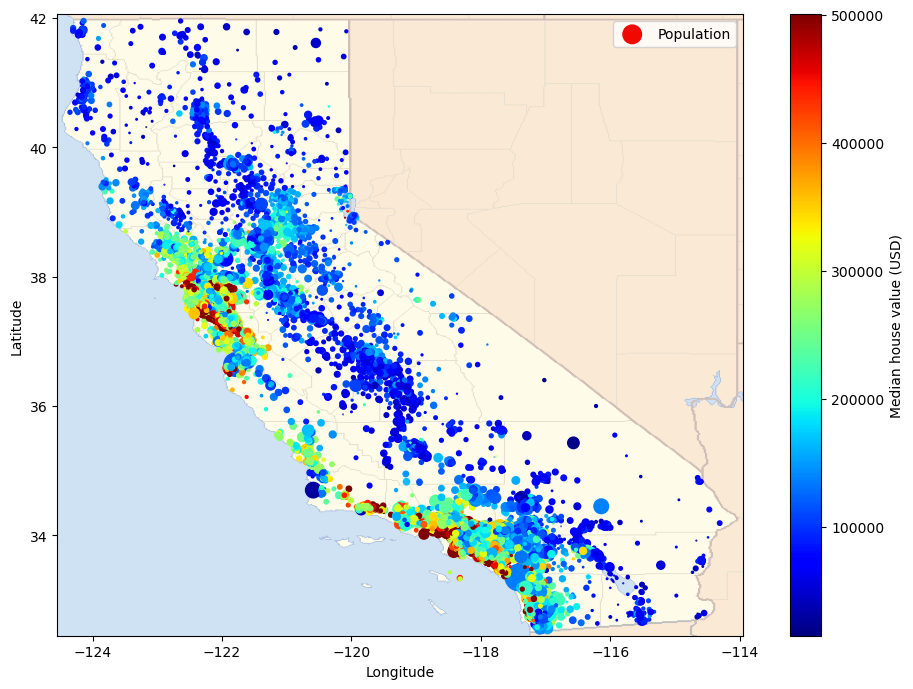

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib.request
from pathlib import Path

# Define the path to save images
IMAGES_PATH = Path("images/end_to_end_project")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# Define the function to save figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Download the California image
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

# Assuming 'housing' DataFrame is already loaded and available
housing = pd.read_csv("datasets/housing/housing.csv")

# Renaming columns for better readability in the plot
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (USD)"
})

# Plotting the data
housing_renamed.plot(
    kind="scatter", x="Longitude", y="Latitude",
    s=housing_renamed["Population"] / 100, label="Population",
    c="Median house value (USD)", cmap="jet", colorbar=True,
    legend=True, sharex=False, figsize=(10, 7)
)

# Load and plot the background image of California
california_img = plt.imread(IMAGES_PATH / filename)
axis = [-124.55, -113.95, 32.45, 42.05]
plt.axis(axis)
plt.imshow(california_img, extent=axis, alpha=0.5)

# Save and show the plot
save_fig("california_housing_prices_plot")
plt.show()


In [46]:
corr_matrix = housing.corr(numeric_only=True)

In [47]:
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

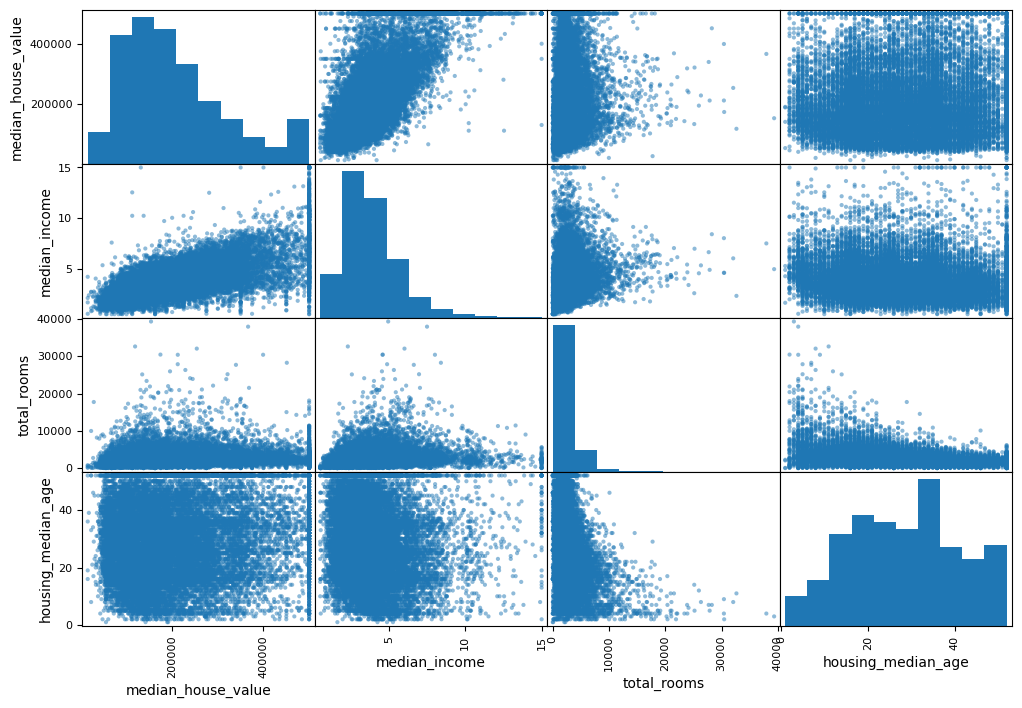

In [48]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

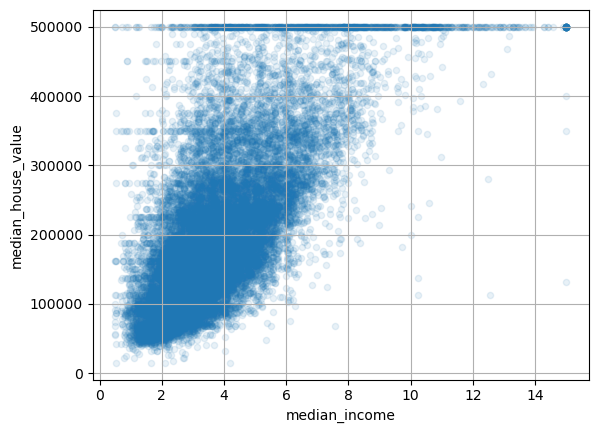

In [49]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.show()

In [50]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [52]:
corr_matrix = housing.corr(numeric_only=True)

In [53]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
rooms_per_house       0.151948
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
people_per_house     -0.023737
population           -0.024650
longitude            -0.045967
latitude             -0.144160
bedrooms_ratio       -0.255880
Name: median_house_value, dtype: float64

In [54]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels= strat_train_set['median_house_value'].copy()

In [55]:
#housing.dropna(subset=["total_bedrooms"], inplace=True)

In [56]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

In [57]:
from sklearn.impute import SimpleImputer

In [58]:
imputer = SimpleImputer(strategy="median")

In [59]:
housing_num = housing.select_dtypes(include=[np.number])

In [60]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [62]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [63]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [64]:
X = imputer.transform(housing_num)

In [65]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [66]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [67]:
from sklearn.preprocessing import OrdinalEncoder

In [68]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [69]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [70]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [71]:
from sklearn.preprocessing import OneHotEncoder

In [72]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [93]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [94]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [95]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [96]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [97]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [98]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [99]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [100]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [101]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [102]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [103]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

In [104]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


In [105]:

from sklearn.preprocessing import MinMaxScaler

In [106]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [107]:
from sklearn.preprocessing import StandardScaler

In [108]:
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [109]:
from sklearn.metrics.pairwise import rbf_kernel

In [110]:
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

In [111]:
from sklearn.linear_model import LinearRegression

In [112]:
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

In [114]:
model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]

In [115]:
scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [116]:
from sklearn.compose import TransformedTargetRegressor

In [117]:
model = TransformedTargetRegressor(LinearRegression(), 
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

In [118]:
from sklearn.preprocessing import FunctionTransformer

In [119]:
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [120]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [121]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

In [122]:
class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean
        
    def fit(self, X, y=None):
        X= check_array(X)
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
            return X/self.scale_ 

In [123]:
from sklearn.cluster import KMeans

In [124]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10,
                 gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None,
            sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters,
                              random_state = self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel( X, self.kmeans_.cluster_centers_,
                          gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [125]:
cluster_simil = ClusterSimilarity(n_clusters=10,
                                  gamma=1.,random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude","longitude"]],
                                           sample_weight=housing_labels)

d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [126]:
similarities[:3].round(2)

array([[0.08, 0.  , 0.6 , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.14],
       [0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.11, 0.  , 0.63, 0.  ],
       [0.44, 0.  , 0.3 , 0.  , 0.  , 0.7 , 0.  , 0.01, 0.  , 0.29]])

In [127]:
from sklearn.pipeline import Pipeline

In [128]:
num_pipeline = Pipeline([{"impute", 
                          SimpleImputer(strategy="median")},
                          ("standardize", StandardScaler()),
                          ])

In [129]:
from sklearn.pipeline import make_pipeline

In [130]:
num_pipeline = make_pipeline(SimpleImputer(strategy=
                                           "median"), StandardScaler())


In [131]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)

In [132]:
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [133]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

In [134]:
from sklearn.compose import ColumnTransformer

In [135]:
num_attribs = ["longitute", "latitude", "housing_median_age",
               "total_rooms", "total_bedrooms", "population",
               "households", "median_income"]
cat_attribs = ["ocean_proximity"]
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
                             OneHotEncoder(handle_unknown="ignore"))
preprocessing = ColumnTransformer([("num", num_pipeline, num_attribs),
                                   ("cat", cat_pipeline, cat_attribs)
                                   ])

In [136]:
from sklearn.compose import make_column_selector, make_column_transformer

In [137]:
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [138]:
housing_prepared = preprocessing.fit_transform(housing)

In [139]:
def column_ratio(X):
    return X[:,[0]]/X[:,[1]]

def ratio_name(function_transformer, feature_name_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio,
                            feature_names_out=ratio_name),
                            StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10,
                                  gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
        ],
        remainder=default_num_pipeline)

In [140]:
housing_prepared = preprocessing.fit_transform(housing)

d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [149]:
housing_prepared.shape

(16512, 24)

In [150]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [151]:
from sklearn.linear_model import LinearRegression

In [152]:
lin_reg = make_pipeline(preprocessing,
                        LinearRegression())
lin_reg.fit(housing, housing_labels)

d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002C5F8E056D0>)])),
                ('linearregression', LinearRegression())])

In [153]:
housing_predictions = lin_reg.predict(housing)

In [154]:
housing_predictions[:5].round(-2)

array([242800., 375900., 127500.,  99400., 324600.])

In [155]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [156]:
from sklearn.metrics import mean_squared_error

In [157]:
lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)

In [158]:
lin_rmse

68647.95686706662

In [159]:
from sklearn.tree import DecisionTreeRegressor

In [160]:
tree_reg = make_pipeline(preprocessing,
                         DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002C5F8E056D0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [161]:
housing_predictions = tree_reg.predict(housing)

In [162]:
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)

In [163]:
tree_rmse

0.0

In [164]:
from sklearn.model_selection import cross_val_score

In [165]:
tree_rmse = - cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error",
                              cv=10)

d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super

In [166]:
pd.Series(tree_rmse).describe()

count       10.000000
mean     67146.519731
std       2125.705276
min      63925.253106
25%      65947.172685
50%      66609.261581
75%      68074.018403
max      70664.635833
dtype: float64

In [167]:
from sklearn.ensemble import RandomForestRegressor

In [169]:
forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                scoring="neg_root_mean_squared_error", cv=10)

d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super

In [170]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47016.874632
std       1054.276130
min      45667.064036
25%      46505.721751
50%      47103.194161
75%      47277.381194
max      49375.687565
dtype: float64

In [172]:
from sklearn.model_selection import GridSearchCV


In [182]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Example preprocessing pipeline component
# Make sure you define the 'geo' step and its parameters correctly
# preprocessing = SomePreprocessingPipeline(...)

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])

param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]

grid_search = GridSearchCV(full_pipeline,
                           param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')

grid_search.fit(housing, housing_labels)


d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002C5F8E056D0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [183]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [184]:
cv_res = pd.DataFrame(grid_search.cv_results_)

In [186]:
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

In [187]:
[...]

[Ellipsis]

In [188]:
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,18.283726,0.029686,0.270207,0.000160,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-43426.405313,-43753.147171,-44532.567341,-43904.039941,464.022327,1
13,23.624752,0.091761,0.272356,0.000701,15,8,"{'preprocessing__geo__n_clusters': 15, 'random...",-44073.089146,-44204.924326,-44981.685091,-44419.899521,400.871882,2
14,28.804351,0.380531,0.272131,0.000872,15,10,"{'preprocessing__geo__n_clusters': 15, 'random...",-44328.010955,-44496.254950,-45212.222299,-44678.829401,383.368837,3
7,18.094261,0.655173,0.248790,0.031088,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44211.527321,-44628.321123,-45805.359075,-44881.735840,674.902057,4
9,18.522422,0.119666,0.249480,0.028952,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44211.527321,-44628.321123,-45805.359075,-44881.735840,674.902057,4


In [189]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [190]:
param_distribs = {'preprocessing__geo__n_clusters': randint(low=3,high=50),
                  'random_forest__max_features': randint(low=2,high=20)}
rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs,
    n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)
rnd_search.fit(housing, housing_labels)

d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002C582001390>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002C581FD0F90>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [191]:
final_model = rnd_search.best_estimator_
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.06, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.01, 0.02,
       0.04, 0.01, 0.  , 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  ,
       0.01, 0.  , 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.03, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.02, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [192]:
sorted(zip(feature_importances,
...            final_model["preprocessing"].get_feature_names_out()),
...            reverse=True)
...

[(0.1898423270105783, 'log__median_income'),
 (0.07709175866873944, 'cat__ocean_proximity_INLAND'),
 (0.06455488601956336, 'bedrooms__ratio'),
 (0.056936146643377976, 'rooms_per_house__ratio'),
 (0.0490294770805355, 'people_per_house__ratio'),
 (0.03807069074492323, 'geo__Cluster 3 similarity'),
 (0.025643913400094472, 'geo__Cluster 22 similarity'),
 (0.02179127543243723, 'geo__Cluster 17 similarity'),
 (0.021575251507503695, 'geo__Cluster 6 similarity'),
 (0.017868654556924362, 'geo__Cluster 2 similarity'),
 (0.017431400050755975, 'geo__Cluster 32 similarity'),
 (0.015981159400591683, 'geo__Cluster 18 similarity'),
 (0.014888464257396877, 'geo__Cluster 40 similarity'),
 (0.014488389218107146, 'geo__Cluster 43 similarity'),
 (0.014252940099964142, 'geo__Cluster 7 similarity'),
 (0.014038173319370725, 'geo__Cluster 21 similarity'),
 (0.013846025114732161, 'geo__Cluster 38 similarity'),
 (0.013625709964722737, 'geo__Cluster 34 similarity'),
 (0.013547297167034428, 'geo__Cluster 41 simila

In [193]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

41549.20158097943


In [194]:
from scipy import stats

In [195]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2

In [196]:
np.sqrt(stats.t.interval(confidence, 
                         len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([39395.35475927, 43596.76969025])

In [197]:
import joblib

In [198]:
joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

In [204]:
#svm

In [209]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [
    {'svr__kernel': ['linear'], 'svr__C': [10.,30., 100.,300.,1000.,
                                           3000.,10000.,30000.]},
    {'svr__kernel': ['rbf'], 'svr__C': [1.0,3.0,10.,30.,100.,300.,
                                        1000.0,],
    'svr__gamma': [0.01,0.03,0.1,0.3,1.0,3.0]},
]

svr_pipeline = Pipeline([("preprocessing", preprocessing), ("svr", SVR())])
grid_search = GridSearchCV(svr_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002C5F8E056D0>)])),
                                       ('svr', SVR())]),
             param_grid=[{'svr__C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                     10000.0, 30000.0],
                          'svr__kernel': ['linear']},
                         {'svr__C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0,
                                     1000.0],
                          'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'svr__kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error')

In [210]:
svr_grid_search_rmse = -grid_search.best_score_
svr_grid_search_rmse

69965.7628757878

In [211]:
grid_search.best_params_

{'svr__C': 10000.0, 'svr__kernel': 'linear'}

In [212]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, loguniform

In [213]:
param_distribs = {
        'svr__kernel': ['linear', 'rbf'],
        'svr__C': loguniform(20, 200_000),
        'svr__gamma': expon(scale=1.0),
    }

rnd_search = RandomizedSearchCV(svr_pipeline,
                                param_distributions=param_distribs,
                                n_iter=50, cv=3,
                                scoring='neg_root_mean_squared_error',
                                random_state=42)
rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid 

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000002C5F8E056D0>)])),
                                             ('svr', SVR())]),
                   n_iter=50,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002C5A2C39F50>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002C582084D90>,
                                        'svr__kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [214]:
svr_rnd_search_rmse = -rnd_search.best_score_
svr_rnd_search_rmse

55805.77371497187

In [215]:
rnd_search.best_params_

{'svr__C': 157055.10989448498,
 'svr__gamma': 0.26497040005002437,
 'svr__kernel': 'rbf'}

In [216]:
np.random.seed(42)

s = expon(scale=1).rvs(100_000)
((s > 0.105) & (s < 2.29)).sum() / 100_000

0.80066

In [219]:
from sklearn.feature_selection import SelectFromModel

In [220]:
selector_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('selector', SelectFromModel(RandomForestRegressor(random_state=42),
                                 threshold=0.005)),
    ('svr', SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"]))
])

In [221]:
selector_rmse = -cross_val_score(selector_pipeline,
                                 housing.iloc[:5000],
                                 housing_labels.iloc[:5000],
                                 scoring="neg_root_mean_squared_error",
                                 cv=3)
pd.Series(selector_rmse).describe()

d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid 

count        3.000000
mean     56157.720107
std       2006.732110
min      53990.350454
25%      55260.963848
50%      56531.577242
75%      57241.404934
max      57951.232626
dtype: float64

In [222]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import MetaEstimatorMixin, clone

class FeatureFromRegressor(MetaEstimatorMixin, BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None):
        estimator_ = clone(self.estimator)
        estimator_.fit(X, y)
        self.estimator_ = estimator_
        self.n_features_in_ = self.estimator_.n_features_in_
        if hasattr(self.estimator, "feature_names_in_"):
            self.feature_names_in_ = self.estimator.feature_names_in_
        return self  # always return self!
    
    def transform(self, X):
        check_is_fitted(self)
        predictions = self.estimator_.predict(X)
        if predictions.ndim == 1:
            predictions = predictions.reshape(-1, 1)
        return predictions

    def get_feature_names_out(self, names=None):
        check_is_fitted(self)
        n_outputs = getattr(self.estimator_, "n_outputs_", 1)
        estimator_class_name = self.estimator_.__class__.__name__
        estimator_short_name = estimator_class_name.lower().replace("_", "")
        return [f"{estimator_short_name}_prediction_{i}"
                for i in range(n_outputs)]

In [223]:
from sklearn.utils.estimator_checks import check_estimator

check_estimator(FeatureFromRegressor(KNeighborsRegressor()))

In [224]:
knn_reg = KNeighborsRegressor(n_neighbors=3, weights="distance")
knn_transformer = FeatureFromRegressor(knn_reg)
geo_features = housing[["latitude", "longitude"]]
knn_transformer.fit_transform(geo_features, housing_labels)

array([[486100.66666667],
       [435250.        ],
       [105100.        ],
       ...,
       [148800.        ],
       [500001.        ],
       [234333.33333333]])

In [225]:
knn_transformer.get_feature_names_out()

['kneighborsregressor_prediction_0']

In [226]:
from sklearn.base import clone

transformers = [(name, clone(transformer), columns)
                for name, transformer, columns in preprocessing.transformers]
geo_index = [name for name, _, _ in transformers].index("geo")
transformers[geo_index] = ("geo", knn_transformer, ["latitude", "longitude"])

new_geo_preprocessing = ColumnTransformer(transformers)

In [227]:
new_geo_pipeline = Pipeline([
    ('preprocessing', new_geo_preprocessing),
    ('svr', SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"])),
])

In [228]:
new_pipe_rmses = -cross_val_score(new_geo_pipeline,
                                  housing.iloc[:5000],
                                  housing_labels.iloc[:5000],
                                  scoring="neg_root_mean_squared_error",
                                  cv=3)
pd.Series(new_pipe_rmses).describe()

count         3.000000
mean     105034.396111
std        2919.196941
min      101811.040419
25%      103801.592804
50%      105792.145190
75%      106646.073957
max      107500.002724
dtype: float64

In [229]:
param_distribs = {
    "preprocessing__geo__estimator__n_neighbors": range(1, 30),
    "preprocessing__geo__estimator__weights": ["distance", "uniform"],
    "svr__C": loguniform(20, 200_000),
    "svr__gamma": expon(scale=1.0),
}

new_geo_rnd_search = RandomizedSearchCV(new_geo_pipeline,
                                        param_distributions=param_distribs,
                                        n_iter=50,
                                        cv=3,
                                        scoring='neg_root_mean_squared_error',
                                        random_state=42)
new_geo_rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=<function ratio_name at 0x000002C5F9B0C2C0>,
                                                                                                                    func=<function column_ratio at 0x000002C5F9B12B60>)),
                                                                                               ('standardscaler',
                                                                                                St...
                   param_distributions={'preprocessing__geo__estimator__n_neighbors': range(1, 30),
                                        'preprocessing__geo__estimator__weights': ['distance',
                                                                                   'uniform'],
                                        'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002C5A3AD0D10>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002C5A3AD3050>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [230]:
new_geo_rnd_search_rmse = -new_geo_rnd_search.best_score_
new_geo_rnd_search_rmse

106867.3603029704

In [231]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X_orig = X
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        if hasattr(X_orig, "columns"):
            self.feature_names_in_ = np.array(X_orig.columns, dtype=object)
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features")
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_
    
    def inverse_transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features")
        X = X * self.scale_
        return X + self.mean_ if self.with_mean else X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return getattr(self, "feature_names_in_",
                           [f"x{i}" for i in range(self.n_features_in_)])
        else:
            if len(input_features) != self.n_features_in_:
                raise ValueError("Invalid number of features")
            if hasattr(self, "feature_names_in_") and not np.all(
                self.feature_names_in_ == input_features
            ):
                raise ValueError("input_features ≠ feature_names_in_")
            return input_features

In [232]:
from sklearn.utils.estimator_checks import check_estimator
 
check_estimator(StandardScalerClone())

In [233]:
np.random.seed(42)
X = np.random.rand(1000, 3)

scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(X)

assert np.allclose(X_scaled, (X - X.mean(axis=0)) / X.std(axis=0))

In [234]:
scaler = StandardScalerClone(with_mean=False)
X_scaled_uncentered = scaler.fit_transform(X)

assert np.allclose(X_scaled_uncentered, X / X.std(axis=0))

In [235]:
scaler = StandardScalerClone()
X_back = scaler.inverse_transform(scaler.fit_transform(X))

assert np.allclose(X, X_back)

In [236]:
assert np.all(scaler.get_feature_names_out() == ["x0", "x1", "x2"])
assert np.all(scaler.get_feature_names_out(["a", "b", "c"]) == ["a", "b", "c"])

In [237]:
df = pd.DataFrame({"a": np.random.rand(100), "b": np.random.rand(100)})
scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(df)

assert np.all(scaler.feature_names_in_ == ["a", "b"])
assert np.all(scaler.get_feature_names_out() == ["a", "b"])